In [1]:
import networkx as nx
import dynetx as dn

import ndlib.models.ModelConfig as mc
import ndlib.models.dynamic as dm

import matplotlib
from matplotlib import pyplot as plt
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from networkx.drawing.nx_pylab import draw_networkx

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook as tqdm
import itertools

In [2]:
matplotlib.rcParams["figure.figsize"] = [6, 5]

### static scale-free network

In [3]:
g = nx.barabasi_albert_graph(5000, 5)

In [4]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 5000
Number of edges: 24975
Average degree:   9.9900


### dynamic network

In [86]:
dg = dn.DynGraph(edge_removal=True)

In [87]:
iterations = range(500)
duration = 3
N = g.number_of_nodes()
l = g.number_of_edges()
edge_lambda = 0.1
node_lambda = 0.01
threshold = 1
party_num = 50

In [58]:
edge_dict = {k: e for k, e in enumerate(g.edges())}

#### add families

In [66]:
def find_clique_edges(cliques):

    return np.concatenate(
        [list(itertools.combinations(clique, r=2)) for clique in cliques]
    )

In [60]:
def remove_duplicate_edges(edges):

    return pd.DataFrame([np.sort(e) for e in edges]).drop_duplicates().values

In [67]:
families = [c for c in nx.enumerate_all_cliques(g) if len(c) in range(3, 6)]

In [36]:
fam_relations = remove_duplicate_edges(find_clique_edges(families))

In [88]:
dg.add_interactions_from(
    fam_relations, t=0, e=iterations[-1]
)

In [89]:
nx.average_clustering(dg)

0.755794722449702

#### add contacts and parties

In [90]:
for i in tqdm(iterations):

    ### sima kontaktok

    n_contacts = int(min(np.random.exponential(edge_lambda), threshold) * l)
    new_contact_IDs = np.random.choice(range(l), n_contacts)
    new_contacts = np.array([edge_dict[ID] for ID in new_contact_IDs])

    ### partik

    if np.random.exponential(0.1) > 0.2:

        party_animals = find_clique_edges([np.random.choice(g.nodes(), party_num)])

        ### összeadjuk a kettőt, kidobjuk a redundánsakat, és hozzáadjuk a hálózathoz

        dg.add_interactions_from(
            remove_duplicate_edges(np.concatenate([new_contacts, party_animals])),
            t=i,
            e=i + duration,
        )

    else:

        dg.add_interactions_from(
            remove_duplicate_edges(new_contacts), t=i, e=i + duration,
        )

In [91]:
print(nx.info(dg))

Name: 
Type: DynGraph
Number of nodes: 5000
Number of edges: 118001
Average degree:  47.2004


In [ ]:
plt.plot([dg.time_slice(t_from=t, t_to=t).number_of_edges() for t in iterations])

In [ ]:
draw_networkx(dg.time_slice(t_from=5), with_labels=False, node_size=20, node_color="orange")
draw_networkx(dg.time_slice(t_from=6), with_labels=False, node_size=20, node_color="purple")

### SIR model

In [94]:
model = dm.DynSIRModel(dg)

In [95]:
config = mc.Configuration()
config.add_model_parameter("fraction_infected", 0.05)
config.add_model_parameter("beta", 0.001)
config.add_model_parameter("gamma", 0.01)
model.set_initial_status(config)

In [96]:
iterations = model.execute_snapshots()

In [97]:
iterations2 = model.execute_iterations()

In [98]:
trends = model.build_trends(iterations)
trends2 = model.build_trends(iterations2)

In [101]:
trends

[{'trends': {'node_count': {0: [4750,
     4750,
     4749,
     4747,
     4745,
     4745,
     4743,
     4741,
     4741,
     4741,
     4740,
     4738,
     4736,
     4736,
     4735,
     4734,
     4733,
     4731,
     4730,
     4729,
     4729,
     4727,
     4727,
     4726,
     4726,
     4725,
     4724,
     4724,
     4722,
     4721,
     4720,
     4718,
     4715,
     4713,
     4711,
     4710,
     4708,
     4705,
     4704,
     4704,
     4701,
     4699,
     4699,
     4699,
     4698,
     4697,
     4696,
     4693,
     4692,
     4692,
     4692,
     4690,
     4690,
     4689,
     4689,
     4689,
     4687,
     4686,
     4683,
     4683,
     4682,
     4682,
     4681,
     4681,
     4681,
     4680,
     4679,
     4679,
     4677,
     4674,
     4674,
     4673,
     4672,
     4671,
     4669,
     4666,
     4665,
     4665,
     4665,
     4665,
     4663,
     4662,
     4661,
     4660,
     4660,
     4660,
     4658,
     4654,
     

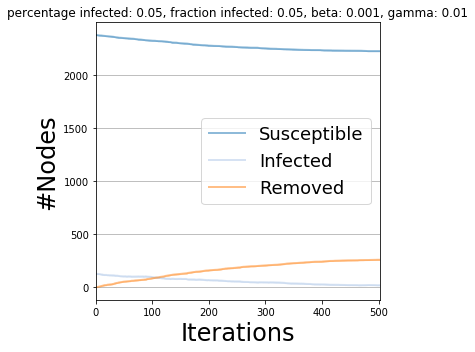

In [99]:
DiffusionTrend(model, trends).plot()

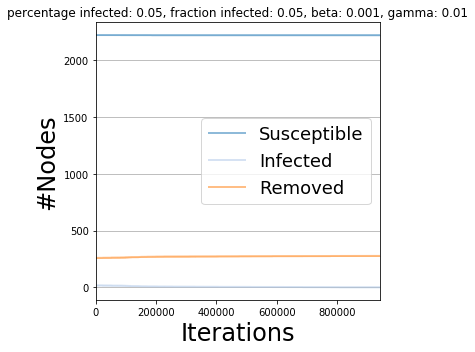

In [100]:
DiffusionTrend(model, trends2).plot()

### composite model

In [32]:
def dynamic_diffusion(dg, iterations=100):

    dc_model = dgc.DynamicCompositeModel(dg)

    for cat in ["Susceptible", "Infected", "Removed"]:
        dc_model.add_status(cat)

    c1 = ns(0.02, triggering_status="Infected")
    c2 = ns(0.01)

    dc_model.add_rule("Susceptible", "Infected", c1)
    dc_model.add_rule("Infected", "Removed", c2)

    config = mc.Configuration()
    config.add_model_parameter('fraction_infected', 0.1)

    dc_model.set_initial_status(config)
    dc_trends = dc_model.build_trends(dc_model.iteration_bunch(iterations))
    
    return dc_model, dc_trends

In [ ]:
m, t = dynamic_diffusion(dg, iterations=500)